# Stock Price Prediction of BEN Stock using LSTM and Simple RNN

In this notebook, I will implement stock price prediction for the NYSE stock General Electric (GE) using an LSTM model. While LSTMs are effective for single-step forecasting, they often struggle with multi-step predictions, resulting in suboptimal performance.

I will change the problem to a binary classification task, where the goal is to predict whether the stock price will increase or decrease in the next time step. This approach allows for a clearer outcome and may yield better results.

## Introduction to RNNs and LSTMs

### Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are designed to process sequential data by maintaining a hidden state that captures information from previous time steps. This ability makes RNNs suitable for tasks such as stock price prediction, language modeling, and time series forecasting.

The core operation of an RNN can be described mathematically as follows:

$$
h_t = f(W_h h_{t-1} + W_x x_t + b)
$$

Where:
- \( h_t \) is the hidden state at time \( t \).
- \( h_{t-1} \) is the hidden state from the previous time step.
- \( x_t \) is the input at time \( t \).
- \( W_h \) and \( W_x \) are weight matrices.
- \( b \) is the bias vector.
- \( f \) is a non-linear activation function (often \( \tanh \) or \( \text{ReLU} \)).

### Simple RNN

The Simple RNN is the most basic form of RNN. It consists of a single layer that updates its hidden state based on the current input and the previous hidden state. However, Simple RNNs can struggle with learning long-term dependencies due to issues such as vanishing and exploding gradients.

### Long Short-Term Memory (LSTM)

LSTMs are a special kind of RNN that address the limitations of Simple RNNs. They introduce memory cells and a gating mechanism to control the flow of information. The three main gates in an LSTM are:

1. **Forget Gate**: 
   - Decides what information to discard from the cell state.
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$

2. **Input Gate**: 
   - Determines what new information to store in the cell state.
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$

3. **Output Gate**: 
   - Decides what to output from the cell state.
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$

The cell state \( C_t \) is updated as follows:
$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$

And the hidden state is updated by:
$$
h_t = o_t \cdot \tanh(C_t)
$$

This architecture enables LSTMs to maintain and manipulate information over long sequences, making them particularly effective for predicting stock prices based on historical data.


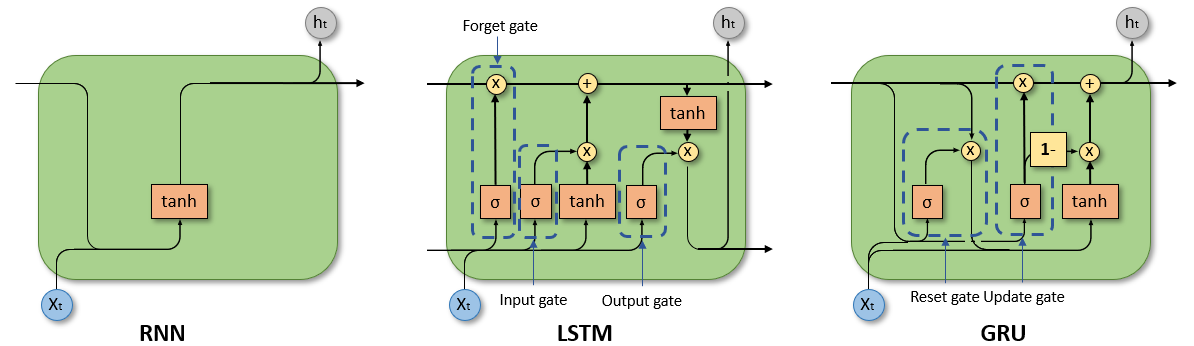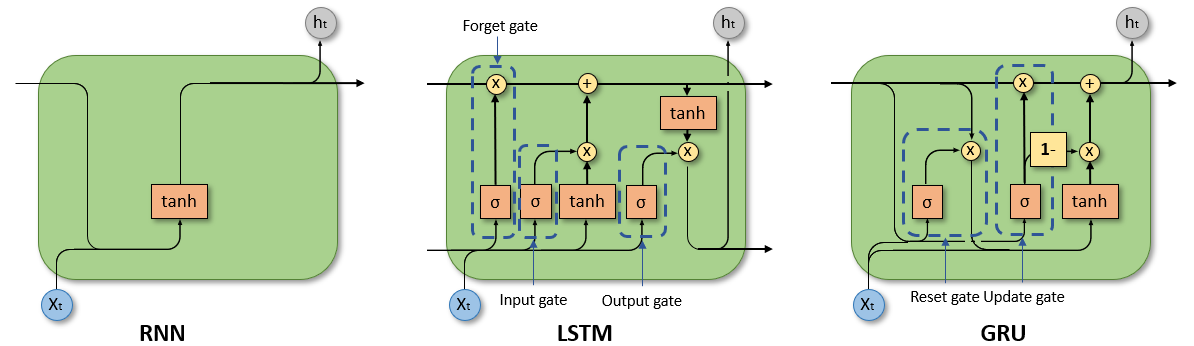

**Image from** [Towards Data Science](https://towardsdatascience.com/a-brief-introduction-to-recurrent-neural-networks-638f64a61ff4)

## Importing Modules

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
df = pd.read_csv('/kaggle/input/stock-market-data/stock_market_data/nyse/csv/BEN.csv')
df.head()

In [ ]:
df.tail()

In [ ]:
print(f"Total rows: {len(df)}")

In [ ]:
series = df.Close.values.reshape(-1, 1)
print(series[:5])
plt.plot(series)

In [ ]:
scaler = StandardScaler()
scaler.fit(series)
series = scaler.transform(series).flatten()

In [ ]:
plt.plot(series)

In [ ]:
T = 10
D = 1
X, Y = [], []

for t in range(len(series)-T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)

print(f"X Shape: {X.shape}, Y Shape: {Y.shape}")

In [ ]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)

model.compile(loss='mse', optimizer=Adam(0.01))

In [ ]:
print(model.summary())

In [ ]:
r = model.fit(X[:-N//2], Y[:-N//2], validation_data=(X[-N//2:], Y[-N//2:]), epochs=100)

In [ ]:
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
preds = model.predict(X).reshape(-1)
plt.plot(preds, label='Predicted')
plt.plot(Y, label='Actual')
plt.title("Single step Prediction (LSTM)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [ ]:
testy = Y[-N//2:]
preds = []

last_x = X[-N//2]

while len(preds)<len(testy):
    p = model.predict(last_x.reshape(1, 10, 1), verbose=None)[0,0]
    preds.append(p)

    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.plot(preds, label='Predicted')
plt.plot(testy, label='Actual')
plt.title("Multi step Prediction (LSTM)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [ ]:
df['PrevClose'] = df['Close'].shift(1)

In [ ]:
print(df.head())

In [ ]:
df['Return'] = (df['Close'] - df['PrevClose'])/ df['PrevClose']
df['Return'].hist()

In [ ]:
series = df['Return'].values[1:].reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series)
series = scaler.transform(series).flatten()

In [ ]:
plt.plot(series)

In [ ]:
T = 10
D = 1
X, Y = [], []

for t in range(len(series)-T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)

print(f"X Shape: {X.shape}, Y Shape: {Y.shape}")

In [ ]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)

model.compile(loss='mse', optimizer=Adam(0.01))

r = model.fit(X[:-N//2], Y[:-N//2], validation_data=(X[-N//2:], Y[-N//2:]), epochs=80)

In [ ]:
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
preds = model.predict(X)
plt.plot(preds, label='Predicted')
plt.plot(Y, label='Actual')
plt.title("Single step Prediction (LSTM)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [ ]:
input_data = df[['Open', 'Low', 'Close', 'High', 'Volume']].values
target = df['Return'].values

In [ ]:
T = 10
D = input_data.shape[1]
N = len(input_data)-T

In [ ]:
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain+T])
input_data = scaler.transform(input_data)

In [ ]:
trainx = np.zeros((Ntrain, T, D))
trainy = np.zeros(Ntrain)

for t in range(Ntrain):
    trainx[t, :, :] = input_data[t:T+t]
    trainy[t] = (target[t+T]>0)

In [ ]:
testx = np.zeros((N - Ntrain, T, D))
testy = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
    t = u + Ntrain
    testx[u, :, :] = input_data[t:T+t]
    testy[u] = (target[t+T]>0)

In [ ]:
i = Input(shape=(T, D))
x = SimpleRNN(1000)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=Adam(0.0001), metrics=['accuracy'])

r = model.fit(trainx, trainy, validation_data=(testx, testy), epochs=100, batch_size=32)

In [ ]:
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()